In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_1.csv
/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv
/kaggle/input/unsw-nb15/UNSW-NB15_LIST_EVENTS.csv
/kaggle/input/unsw-nb15/UNSW-NB15_4.csv
/kaggle/input/unsw-nb15/UNSW-NB15_3.csv
/kaggle/input/unsw-nb15/UNSW-NB15_2.csv
/kaggle/input/unsw-nb15/NUSW-NB15_features.csv


In [3]:
import pandas as pd

# Load the dataset
file_path = "/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv"  # Adjust the path if the file is elsewhere
try:
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"File not found at {file_path}. Please ensure the path is correct.")
    exit()

# Display basic information about the dataset
print("\nDataset Info:")
print(data.info())

print("\nFirst 5 rows of the dataset:")
print(data.head())

# Check for missing values
print("\nMissing values per column:")
print(data.isnull().sum())


Dataset loaded successfully!

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 n

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load the dataset
file_path = "/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv"
data = pd.read_csv(file_path)

# Step 1: Encode categorical features
categorical_columns = ['proto', 'service', 'state', 'attack_cat']
encoders = {col: LabelEncoder() for col in categorical_columns}

for col in categorical_columns:
    data[col] = encoders[col].fit_transform(data[col])

# Step 2: Normalize numerical features
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.drop(['id', 'label'])
scaler = MinMaxScaler()

data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

# Step 3: Verify the processed dataset
print("\nProcessed Dataset (first 5 rows):")
print(data.head())

# Save the processed data for the next steps
processed_file_path = "processed_training_set.csv"
data.to_csv(processed_file_path, index=False)
print(f"\nProcessed data saved to {processed_file_path}")



Processed Dataset (first 5 rows):
   id           dur  proto  service     state     spkts  dpkts    sbytes  \
0   1  1.833334e-07    0.9      0.0  0.666667  0.000094    0.0  0.000033   
1   2  1.333334e-07    0.9      0.0  0.666667  0.000094    0.0  0.000121   
2   3  8.333335e-08    0.9      0.0  0.666667  0.000094    0.0  0.000073   
3   4  1.000000e-07    0.9      0.0  0.666667  0.000094    0.0  0.000061   
4   5  1.666667e-07    0.9      0.0  0.666667  0.000094    0.0  0.000146   

   dbytes      rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0     0.0  0.090909  ...               0.0        0.016129           0.0   
1     0.0  0.125000  ...               0.0        0.016129           0.0   
2     0.0  0.200000  ...               0.0        0.032258           0.0   
3     0.0  0.166667  ...               0.0        0.032258           0.0   
4     0.0  0.100000  ...               0.0        0.032258           0.0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv

In [5]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pickle  # For saving as a binary file

# Load the preprocessed dataset
file_path = "processed_training_set.csv"
data = pd.read_csv(file_path)

# Step 1: Define nodes and their features
node_features = data.drop(['id', 'label'], axis=1).values
node_labels = data['label'].values
num_nodes = data.shape[0]

# Step 2: Create a graph
G = nx.Graph()

# Add nodes with features
for i in range(num_nodes):
    G.add_node(i, features=node_features[i].tolist(), label=int(node_labels[i]))  # Convert numpy array to list for JSON compatibility

# Step 3: Define edges using KNN
k = 5
knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(node_features)

distances, neighbors = knn.kneighbors(node_features)

# Add edges
for i in range(num_nodes):
    for j in neighbors[i]:
        if i != j:
            G.add_edge(i, j)

# Step 4: Save the graph using pickle
graph_file_path = "graph_data.pkl"
with open(graph_file_path, "wb") as f:
    pickle.dump(G, f)
print(f"Graph saved to {graph_file_path} using pickle.")


Graph saved to graph_data.pkl using pickle.


In [6]:
!pip install torch-geometric
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-<torch_version>+<cuda_version>.html


/bin/bash: line 1: torch_version: No such file or directory


In [7]:
import pickle
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Step 1: Load the graph from the pickle file
graph_file_path = "graph_data.pkl"
with open(graph_file_path, "rb") as f:
    G = pickle.load(f)

print(f"Graph loaded with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# Step 2: Convert the NetworkX graph to PyTorch Geometric Data
data = from_networkx(G)

# Step 3: Prepare node features and labels
# Extract node features (already stored in 'features' attribute)
data.x = torch.tensor([G.nodes[i]['features'] for i in range(G.number_of_nodes())], dtype=torch.float)

# Extract labels (already stored in 'label' attribute)
data.y = torch.tensor([G.nodes[i]['label'] for i in range(G.number_of_nodes())], dtype=torch.long)

print(f"PyTorch Geometric Data object created:")
print(data)

# Step 4: Save the PyTorch Geometric Data object for later use
torch.save(data, "graph_data.pt")
print("PyTorch Geometric Data object saved to graph_data.pt.")


Graph loaded with 82332 nodes and 241884 edges.
PyTorch Geometric Data object created:
Data(edge_index=[2, 483768], features=[82332, 43], label=[82332], num_nodes=82332, x=[82332, 43], y=[82332])
PyTorch Geometric Data object saved to graph_data.pt.


In [8]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Load the PyTorch Geometric Data object
data_path = "graph_data.pt"
data = torch.load(data_path)

# Define the GNN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer, and loss function
model = GCN(in_channels=data.x.size(1), hidden_channels=64, out_channels=2)  # 2 classes: Normal/Anomaly
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Move data and model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = model.to(device)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)  # Forward pass
    loss = criterion(out, data.y)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    return loss.item()

# Testing function
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum()
        acc = int(correct) / data.num_nodes
    return acc

# Train the model
for epoch in range(1, 201):  # Train for 200 epochs
    loss = train()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


<ipython-input-8-814a190abc67>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Epoch 010, Loss: 0.4076, Test Accuracy: 0.8625
Epoch 020, Loss: 0.2592, Test Accuracy: 0.9144
Epoch 030, Loss: 0.1941, Test Accuracy: 0.9272
Epoch 040, Loss: 0.1708, Test Accuracy: 0.9258
Epoch 050, Loss: 0.1631, Test Accuracy: 0.9287
Epoch 060, Loss: 0.1584, Test Accuracy: 0.9304
Epoch 070, Loss: 0.1535, Test Accuracy: 0.9337
Epoch 080, Loss: 0.1491, Test Accuracy: 0.9365
Epoch 090, Loss: 0.1442, Test Accuracy: 0.9379
Epoch 100, Loss: 0.1387, Test Accuracy: 0.9412
Epoch 110, Loss: 0.1335, Test Accuracy: 0.9434
Epoch 120, Loss: 0.1263, Test Accuracy: 0.9477
Epoch 130, Loss: 0.1195, Test Accuracy: 0.9512
Epoch 140, Loss: 0.1131, Test Accuracy: 0.9541
Epoch 150, Loss: 0.1070, Test Accuracy: 0.9563
Epoch 160, Loss: 0.1009, Test Accuracy: 0.9587
Epoch 170, Loss: 0.0950, Test Accuracy: 0.9623
Epoch 180, Loss: 0.0892, Test Accuracy: 0.9651
Epoch 190, Loss: 0.0838, Test Accuracy: 0.9689
Epoch 200, Loss: 0.0792, Test Accuracy: 0.9756


In [9]:
from sklearn.metrics import classification_report

def evaluate_model():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1).cpu()
        true = data.y.cpu()
        print(classification_report(true, pred, target_names=['Normal', 'Anomalous']))

evaluate_model()


              precision    recall  f1-score   support

      Normal       0.96      0.98      0.97     37000
   Anomalous       0.98      0.97      0.98     45332

    accuracy                           0.98     82332
   macro avg       0.97      0.98      0.98     82332
weighted avg       0.98      0.98      0.98     82332



In [10]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GAT model
gat_model = GAT(
    in_channels=data.x.size(1),
    hidden_channels=64,
    out_channels=2,  # Binary classification
    heads=8
).to(device)

# Use the same optimizer and loss function
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
gat_criterion = torch.nn.CrossEntropyLoss()

# Training loop for GAT
def train_gat():
    gat_model.train()
    gat_optimizer.zero_grad()
    out = gat_model(data.x, data.edge_index)
    loss = gat_criterion(out, data.y)
    loss.backward()
    gat_optimizer.step()
    return loss.item()

# Test function remains the same
# Train GAT
for epoch in range(1, 201):
    loss = train_gat()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Epoch 010, Loss: 0.3889, Test Accuracy: 0.9756
Epoch 020, Loss: 0.2655, Test Accuracy: 0.9756
Epoch 030, Loss: 0.2220, Test Accuracy: 0.9756
Epoch 040, Loss: 0.2067, Test Accuracy: 0.9756
Epoch 050, Loss: 0.1991, Test Accuracy: 0.9756
Epoch 060, Loss: 0.1925, Test Accuracy: 0.9756
Epoch 070, Loss: 0.1870, Test Accuracy: 0.9756
Epoch 080, Loss: 0.1800, Test Accuracy: 0.9756
Epoch 090, Loss: 0.1724, Test Accuracy: 0.9756
Epoch 100, Loss: 0.1676, Test Accuracy: 0.9756
Epoch 110, Loss: 0.1566, Test Accuracy: 0.9756
Epoch 120, Loss: 0.1479, Test Accuracy: 0.9756
Epoch 130, Loss: 0.1401, Test Accuracy: 0.9756
Epoch 140, Loss: 0.1344, Test Accuracy: 0.9756
Epoch 150, Loss: 0.1270, Test Accuracy: 0.9756
Epoch 160, Loss: 0.1205, Test Accuracy: 0.9756
Epoch 170, Loss: 0.1150, Test Accuracy: 0.9756
Epoch 180, Loss: 0.1088, Test Accuracy: 0.9756
Epoch 190, Loss: 0.1078, Test Accuracy: 0.9756
Epoch 200, Loss: 0.1028, Test Accuracy: 0.9756


In [11]:
def visualize_attention():
    gat_model.eval()
    with torch.no_grad():
        # Get attention weights from the first GAT layer
        x, (edge_index, attn_weights) = gat_model.conv1(data.x, data.edge_index, return_attention_weights=True)
        
        # Print attention weights shape and some sample values
        print("Attention Weights Shape:", attn_weights.shape)
        print("Sample Attention Weights:", attn_weights[:10])  # Show first 10 attention weights
        
        return edge_index, attn_weights

# Visualize attention weights
edge_index, attention_weights = visualize_attention()


Attention Weights Shape: torch.Size([566100, 8])
Sample Attention Weights: tensor([[0.1667, 0.1668, 0.1667, 0.1667, 0.1666, 0.1667, 0.1667, 0.1667],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1428, 0.1428, 0.1428, 0.1429],
        [0.1250, 0.1249, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1666, 0.1665, 0.1666, 0.1667, 0.1668, 0.1667, 0.1667, 0.1666],
        [0.1249, 0.1248, 0.1249, 0.1250, 0.1251, 0.1250, 0.1250, 0.1250],
        [0.1250, 0.1251, 0.1250, 0.1250, 0.1249, 0.1249, 0.1249, 0.1250],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250],
        [0.1999, 0.1997, 0.1999, 0.2000, 0.2001, 0.2000, 0.2000, 0.1999],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1430, 0.1429, 0.1429],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1251, 0.1251, 0.1251, 0.1250]],
       device='cuda:0')


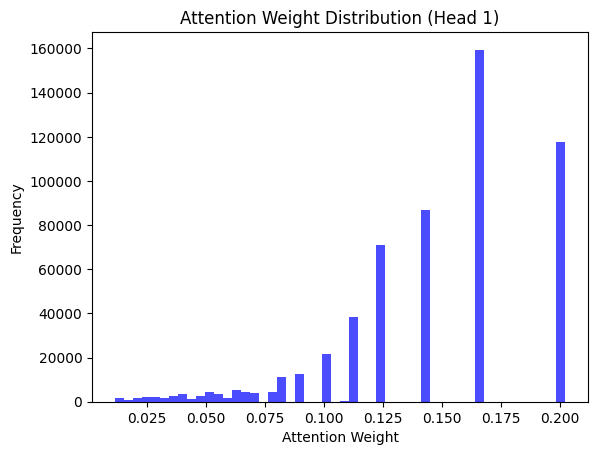

In [12]:
import matplotlib.pyplot as plt

# Plot the distribution of attention weights for the first attention head
def plot_attention_weights(attn_weights):
    first_head = attn_weights[:, 0].cpu().numpy()  # Extract the first attention head
    plt.hist(first_head, bins=50, color='blue', alpha=0.7)
    plt.title("Attention Weight Distribution (Head 1)")
    plt.xlabel("Attention Weight")
    plt.ylabel("Frequency")
    plt.show()

plot_attention_weights(attention_weights)


In [13]:
def get_top_attention_edges(edge_index, attn_weights, top_k=10):
    # Get the mean attention across heads for each edge
    mean_attention = attn_weights.mean(dim=1)
    
    # Get top K edges based on attention weights
    top_edges = mean_attention.topk(top_k, largest=True)
    top_indices = top_edges.indices.cpu().numpy()
    top_values = top_edges.values.cpu().numpy()
    
    # Print the top edges with their attention scores
    print("Top Attention Edges (Mean Attention):")
    for i, idx in enumerate(top_indices):
        print(f"Edge: {edge_index[:, idx].cpu().numpy()}, Attention: {top_values[i]:.4f}")

# Get top 10 edges with highest attention
get_top_attention_edges(edge_index, attention_weights)


Top Attention Edges (Mean Attention):
Edge: [ 8342 77089], Attention: 0.2018
Edge: [976 976], Attention: 0.2017
Edge: [47119 59795], Attention: 0.2015
Edge: [44720   821], Attention: 0.2015
Edge: [65780 65781], Attention: 0.2015
Edge: [65781 65781], Attention: 0.2015
Edge: [65781 65780], Attention: 0.2015
Edge: [65780 65780], Attention: 0.2015
Edge: [10102 80316], Attention: 0.2015
Edge: [10102 80317], Attention: 0.2015


In [14]:
def extract_subgraph(edge_index, top_indices):
    top_edges = edge_index[:, top_indices]
    # Move to CPU and convert to NumPy for display
    print(f"Top Subgraph Edges: {top_edges.T.cpu().numpy()}")  
    return top_edges

# Extract and display subgraph for top edges
top_indices = torch.topk(attention_weights.mean(dim=1), 10).indices
top_subgraph = extract_subgraph(edge_index, top_indices)


Top Subgraph Edges: [[ 8342 77089]
 [  976   976]
 [47119 59795]
 [44720   821]
 [65780 65781]
 [65781 65781]
 [65781 65780]
 [65780 65780]
 [10102 80316]
 [10102 80317]]


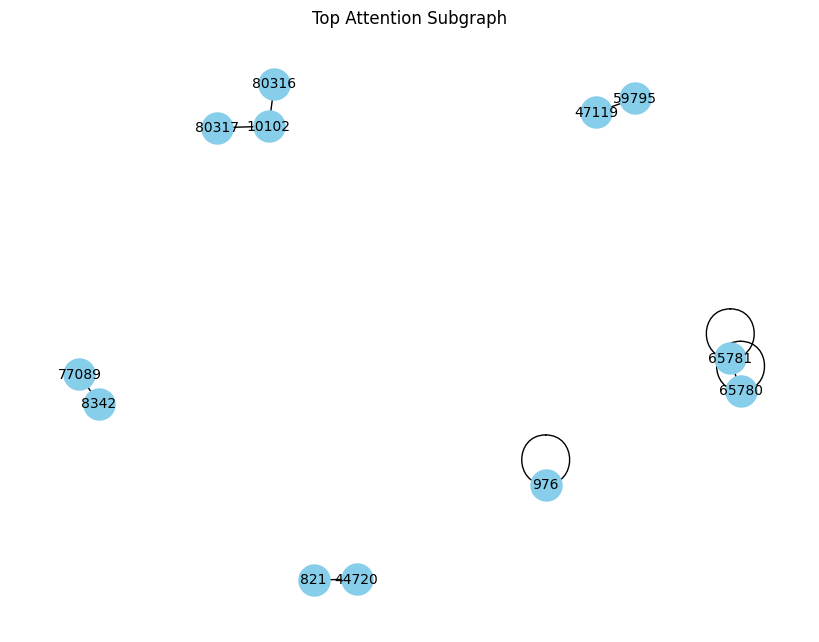

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a NetworkX graph from the top subgraph
def visualize_subgraph(edge_index, top_edges):
    # Convert to a NetworkX graph
    G = nx.Graph()
    for edge in top_edges.T.cpu().numpy():
        G.add_edge(edge[0], edge[1])

    # Plot the subgraph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(
        G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_color="black"
    )
    plt.title("Top Attention Subgraph")
    plt.show()

# Visualize the subgraph
visualize_subgraph(edge_index, top_subgraph)


In [16]:
from torch_geometric.data import DataLoader

# Real-time simulation with batch processing
def simulate_real_time(data, batch_size=1024):
    loader = DataLoader([data], batch_size=batch_size, shuffle=False)
    gat_model.eval()
    all_preds = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = gat_model(batch.x, batch.edge_index)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            print(f"Batch Predictions: {pred[:10].cpu().numpy()}")  # Display first 10 predictions per batch
    
    return all_preds

# Simulate real-time predictions
real_time_preds = simulate_real_time(data)


Batch Predictions: [0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [17]:
# Extract nodes in the top-attention subgraph
def evaluate_subgraph_performance(edge_index, top_edges, preds, labels):
    subgraph_nodes = set(top_edges.flatten().cpu().numpy())
    subgraph_preds = [preds[i] for i in subgraph_nodes]
    subgraph_labels = [labels[i].item() for i in subgraph_nodes]
    
    # Calculate accuracy
    correct = sum(p == l for p, l in zip(subgraph_preds, subgraph_labels))
    accuracy = correct / len(subgraph_nodes)
    print(f"Subgraph Prediction Accuracy: {accuracy:.4f}")

# Evaluate subgraph performance
evaluate_subgraph_performance(edge_index, top_subgraph, real_time_preds, data.y)


Subgraph Prediction Accuracy: 0.6667


In [18]:
# Compute class weights
normal_count = (data.y == 0).sum().item()
anomaly_count = (data.y == 1).sum().item()
total_count = normal_count + anomaly_count
weights = torch.tensor([1.0 / normal_count, 1.0 / anomaly_count]) * total_count
weights = weights.to(device)

# Update the criterion
criterion = torch.nn.CrossEntropyLoss(weight=weights)

# Retrain the GAT model with the weighted loss
for epoch in range(1, 201):
    loss = train_gat()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Epoch 010, Loss: 0.0992, Test Accuracy: 0.9756
Epoch 020, Loss: 0.0964, Test Accuracy: 0.9756
Epoch 030, Loss: 0.0940, Test Accuracy: 0.9756
Epoch 040, Loss: 0.0905, Test Accuracy: 0.9756
Epoch 050, Loss: 0.0893, Test Accuracy: 0.9756
Epoch 060, Loss: 0.0883, Test Accuracy: 0.9756
Epoch 070, Loss: 0.0871, Test Accuracy: 0.9756
Epoch 080, Loss: 0.0840, Test Accuracy: 0.9756
Epoch 090, Loss: 0.0839, Test Accuracy: 0.9756
Epoch 100, Loss: 0.0825, Test Accuracy: 0.9756
Epoch 110, Loss: 0.0816, Test Accuracy: 0.9756
Epoch 120, Loss: 0.0800, Test Accuracy: 0.9756
Epoch 130, Loss: 0.0802, Test Accuracy: 0.9756
Epoch 140, Loss: 0.0780, Test Accuracy: 0.9756
Epoch 150, Loss: 0.0785, Test Accuracy: 0.9756
Epoch 160, Loss: 0.0774, Test Accuracy: 0.9756
Epoch 170, Loss: 0.0761, Test Accuracy: 0.9756
Epoch 180, Loss: 0.0776, Test Accuracy: 0.9756
Epoch 190, Loss: 0.0764, Test Accuracy: 0.9756
Epoch 200, Loss: 0.0756, Test Accuracy: 0.9756


In [19]:
def prioritize_subgraph_nodes(data, subgraph_nodes):
    mask = torch.zeros(data.num_nodes, dtype=torch.bool, device=data.y.device)
    mask[list(subgraph_nodes)] = True
    return mask

# Use subgraph nodes as priority during training
subgraph_mask = prioritize_subgraph_nodes(data, set(top_subgraph.flatten().cpu().numpy()))

# Example: Sample weighted batches for training
batch_size = 1024
subgraph_data = data.clone()
subgraph_data.x = subgraph_data.x[subgraph_mask]
subgraph_data.y = subgraph_data.y[subgraph_mask]

# Retrain using subgraph-prioritized batches


In [20]:
def analyze_feature_distributions(data, subgraph_mask):
    global_features = data.x.mean(dim=0).cpu().numpy()
    subgraph_features = data.x[subgraph_mask].mean(dim=0).cpu().numpy()
    print("Global Feature Means:", global_features)
    print("Subgraph Feature Means:", subgraph_features)

# Compare global vs subgraph feature distributions
analyze_feature_distributions(data, subgraph_mask)


Global Feature Means: [1.67792719e-02 8.41140568e-01 1.18474595e-01 5.62458575e-01
 1.65960274e-03 1.59247930e-03 5.55171922e-04 9.02866013e-04
 8.24108869e-02 7.09677160e-01 3.78312260e-01 1.22530404e-02
 3.02840285e-02 8.93719203e-04 1.14555215e-03 1.25878081e-02
 2.10777414e-03 4.28827526e-03 1.15540007e-03 5.23369014e-01
 2.52538830e-01 2.49940515e-01 5.03084779e-01 1.46344518e-02
 9.06657986e-03 9.10588447e-03 7.80598745e-02 7.75167122e-02
 7.19670497e-04 3.04293062e-04 1.37848452e-01 2.28212193e-01
 8.18090290e-02 6.77396208e-02 7.19732717e-02 1.04134813e-01
 4.14176751e-03 4.19035135e-03 8.10893718e-03 9.26840752e-02
 1.33840352e-01 1.11256866e-02 5.54195225e-01]
Subgraph Feature Means: [2.8437898e-02 8.5384619e-01 3.3333331e-01 5.0000000e-01 2.1136685e-03
 8.4558614e-03 9.2587768e-05 7.9223774e-03 5.6908153e-05 6.8235296e-01
 9.9604744e-01 1.5907249e-06 1.7548643e-02 4.2301184e-04 8.0806250e-03
 1.5310857e-03 1.0462353e-03 3.5772254e-03 1.9554407e-03 1.0000000e+00
 5.2596360e-0

In [21]:
def adjust_features(data, sparse_threshold=0.01):
    # Identify sparse features
    global_mean = data.x.mean(dim=0).cpu()
    sparse_features = (global_mean < sparse_threshold).nonzero(as_tuple=True)[0]
    
    print(f"Sparse Features: {sparse_features.tolist()}")
    
    # Remove sparse features from the dataset
    data.x = torch.cat([data.x[:, i:i+1] for i in range(data.x.size(1)) if i not in sparse_features], dim=1)
    return data

# Adjust features and retrain
data = adjust_features(data)


Sparse Features: [4, 5, 6, 7, 13, 14, 16, 17, 18, 24, 25, 28, 29, 36, 37, 38]


In [22]:
# Re-initialize the model with updated input dimensions
new_input_dim = data.x.size(1)  # Automatically detect input feature dimension
gat_model = GAT(
    in_channels=new_input_dim,  # Update input dimension
    hidden_channels=64,
    out_channels=2,  # Binary classification
    heads=8
).to(device)

# Reinitialize optimizer and criterion if needed
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)


In [23]:
print(f"Updated Feature Dimension: {data.x.shape[1]}")


Updated Feature Dimension: 27


In [24]:
# Delete the old model and optimizer
del gat_model, optimizer
torch.cuda.empty_cache()  # Clear GPU memory


In [25]:
print(f"Input Feature Dimension: {data.x.shape[1]}")  # Should print 27


Input Feature Dimension: 27


In [26]:
from torch_geometric.nn import GATConv

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GAT model with 27 input features
gat_model = GAT(
    in_channels=27,  # Correct input feature dimension
    hidden_channels=64,
    out_channels=2,  # Binary classification
    heads=8
).to(device)


In [27]:
# Reinitialize optimizer and criterion
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [28]:
print(f"GAT Input Channels (conv1): {gat_model.conv1.in_channels}")


GAT Input Channels (conv1): 27


In [29]:
import gc
import torch

# Clear existing models and optimizers
del gat_model, optimizer
gc.collect()
torch.cuda.empty_cache()  # Clear GPU memory


In [30]:
# Confirm feature dimensions
print(f"Input Feature Shape: {data.x.shape}")  # Should print (82332, 27)


Input Feature Shape: torch.Size([82332, 27])


In [31]:
# Debugging the GATConv initialization
gat_layer = GATConv(in_channels=27, out_channels=64, heads=8)
print(f"GATConv Input Channels: {gat_layer.in_channels}, Expected Output Shape: {gat_layer.out_channels * gat_layer.heads}")


GATConv Input Channels: 27, Expected Output Shape: 512


In [32]:
# Define the updated GAT model
gat_model = GAT(
    in_channels=27,  # Correct feature dimension
    hidden_channels=64,
    out_channels=2,  # Binary classification
    heads=8
).to(device)

# Reinitialize optimizer and criterion
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Verify the model structure
print(gat_model)


GAT(
  (conv1): GATConv(27, 64, heads=8)
  (conv2): GATConv(512, 2, heads=1)
)


In [33]:
# Test a forward pass
try:
    gat_model.eval()
    with torch.no_grad():
        out = gat_model(data.x, data.edge_index)
        print(f"Forward Pass Output Shape: {out.shape}")
except Exception as e:
    print(f"Error During Forward Pass: {e}")


Forward Pass Output Shape: torch.Size([82332, 2])


In [34]:
import gc
import torch

# Delete all model-related objects
del gat_model, optimizer, criterion
gc.collect()
torch.cuda.empty_cache()


In [35]:
gat_model = GAT(
    in_channels=27,  # Match reduced feature dimension
    hidden_channels=64,
    out_channels=2,  # Binary classification
    heads=8
).to(device)

optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()


In [36]:
for name, param in gat_model.named_parameters():
    print(f"{name}: {param.shape}")


conv1.att_src: torch.Size([1, 8, 64])
conv1.att_dst: torch.Size([1, 8, 64])
conv1.bias: torch.Size([512])
conv1.lin.weight: torch.Size([512, 27])
conv2.att_src: torch.Size([1, 1, 2])
conv2.att_dst: torch.Size([1, 1, 2])
conv2.bias: torch.Size([2])
conv2.lin.weight: torch.Size([2, 512])


In [37]:
gat_model.eval()
with torch.no_grad():
    out = gat_model(data.x, data.edge_index)
    print(f"Forward Pass Output Shape: {out.shape}")  # Should be (82332, 2)


Forward Pass Output Shape: torch.Size([82332, 2])


In [38]:
def train_gat():
    model.train()
    optimizer.zero_grad()
    print(f"Training Input Shape: {data.x.shape}")  # Debug
    out = gat_model(data.x, data.edge_index)
    print(f"Training Output Shape: {out.shape}")  # Debug
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        print(f"Testing Input Shape: {data.x.shape}")  # Debug
        out = gat_model(data.x, data.edge_index)
        print(f"Testing Output Shape: {out.shape}")  # Debug
        pred = out.argmax(dim=1)
        correct = (pred == data.y).sum()
    return int(correct) / data.num_nodes


In [39]:
for epoch in range(1, 201):
    loss = train_gat()
    if epoch % 10 == 0:
        acc = test()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Training Input Shape: torch.Size([82332, 27])
Training Output Shape: torch.Size([82332, 2])
Testing Input Shape: torch.Size([82332, 27])
Testing Output Shape: torch.Size([8

In [40]:
from sklearn.metrics import classification_report

def evaluate_model():
    model.eval()
    with torch.no_grad():
        out = gat_model(data.x, data.edge_index)
        pred = out.argmax(dim=1).cpu()
        true = data.y.cpu()
        print(classification_report(true, pred, target_names=['Normal', 'Anomalous']))

evaluate_model()


              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     37000
   Anomalous       0.99      0.98      0.98     45332

    accuracy                           0.98     82332
   macro avg       0.98      0.98      0.98     82332
weighted avg       0.98      0.98      0.98     82332



In [41]:
torch.save(gat_model.state_dict(), "gat_model.pt")
print("Model saved as 'gat_model.pt'")


Model saved as 'gat_model.pt'


In [42]:
from torch_geometric.data import DataLoader

# Real-time prediction simulation
def simulate_real_time(data, batch_size=1024):
    loader = DataLoader([data], batch_size=batch_size, shuffle=False)
    gat_model.eval()
    all_preds = []
    
    print("Simulating real-time anomaly detection...")
    with torch.no_grad():
        for i, batch in enumerate(loader):
            batch = batch.to(device)
            out = gat_model(batch.x, batch.edge_index)
            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            print(f"Batch {i + 1} Predictions (first 10): {pred[:10].cpu().numpy()}")  # Show first 10 predictions
    
    print("Real-time simulation completed!")
    return all_preds

# Simulate real-time detection
real_time_preds = simulate_real_time(data)


Simulating real-time anomaly detection...
Batch 1 Predictions (first 10): [0 0 0 0 0 0 0 0 0 0]
Real-time simulation completed!


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [43]:
from torch.autograd import grad

def grad_cam_node(node_idx, data, model):
    model.eval()
    data = data.to(device)
    
    # Enable gradients for the input features
    data.x.requires_grad = True
    
    # Forward pass
    out = model(data.x, data.edge_index)
    target_class = out[node_idx].argmax()
    
    # Backpropagate for the target class
    model.zero_grad()
    out[node_idx, target_class].backward()
    
    # Calculate Grad-CAM heatmap
    node_grad = data.x.grad[node_idx].cpu().numpy()
    heatmap = node_grad / (node_grad.max() + 1e-8)  # Normalize
    print(f"Grad-CAM Heatmap for Node {node_idx}: {heatmap}")
    return heatmap

# Example: Get Grad-CAM for a specific node (e.g., node 0)
node_idx = 0
heatmap = grad_cam_node(node_idx, data, gat_model)


Grad-CAM Heatmap for Node 0: [ 0.08224489  0.28070274 -0.24839233 -0.0816724   0.0689877  -0.17173767
 -0.21537296 -0.08571803  0.06880119  0.18191637  0.3022557   0.00571091
  0.00663248  0.020401    0.8921238   0.24316841  0.10579494  0.20009705
  0.03086172  0.09788878  0.03571475 -0.49500096  1.          0.01784717
  0.60402143  0.14926705 -0.2357602 ]


In [44]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize GraphSAGE model
sage_model = GraphSAGE(in_channels=27, hidden_channels=64, out_channels=2).to(device)

# Train the GraphSAGE model using the same pipeline
optimizer = torch.optim.Adam(sage_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop remains the same
for epoch in range(1, 201):
    sage_model.train()
    optimizer.zero_grad()
    out = sage_model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        sage_model.eval()
        with torch.no_grad():
            out = sage_model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            acc = int((pred == data.y).sum()) / data.num_nodes
            print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Epoch 010, Loss: 0.4584, Test Accuracy: 0.7397
Epoch 020, Loss: 0.3144, Test Accuracy: 0.9123
Epoch 030, Loss: 0.2254, Test Accuracy: 0.9160
Epoch 040, Loss: 0.1869, Test Accuracy: 0.9206
Epoch 050, Loss: 0.1702, Test Accuracy: 0.9270
Epoch 060, Loss: 0.1635, Test Accuracy: 0.9269
Epoch 070, Loss: 0.1583, Test Accuracy: 0.9292
Epoch 080, Loss: 0.1529, Test Accuracy: 0.9316
Epoch 090, Loss: 0.1479, Test Accuracy: 0.9323
Epoch 100, Loss: 0.1432, Test Accuracy: 0.9330
Epoch 110, Loss: 0.1387, Test Accuracy: 0.9351
Epoch 120, Loss: 0.1344, Test Accuracy: 0.9383
Epoch 130, Loss: 0.1299, Test Accuracy: 0.9424
Epoch 140, Loss: 0.1255, Test Accuracy: 0.9463
Epoch 150, Loss: 0.1208, Test Accuracy: 0.9495
Epoch 160, Loss: 0.1152, Test Accuracy: 0.9530
Epoch 170, Loss: 0.1103, Test Accuracy: 0.9555
Epoch 180, Loss: 0.1044, Test Accuracy: 0.9597
Epoch 190, Loss: 0.0985, Test Accuracy: 0.9629
Epoch 200, Loss: 0.0911, Test Accuracy: 0.9670


In [45]:
from torch_geometric.nn import GINConv
from torch.nn import Sequential, Linear, ReLU

class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GIN, self).__init__()
        # Update Linear layers in GINConv
        nn1 = Sequential(Linear(in_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        nn2 = Sequential(Linear(hidden_channels, hidden_channels), ReLU(), Linear(hidden_channels, hidden_channels))
        self.conv1 = GINConv(nn1)
        self.conv2 = GINConv(nn2)
        self.fc = Linear(hidden_channels, out_channels)  # Map hidden channels to out_channels

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)  # Fully connected layer for output
        return x

# Initialize GIN model
gin_model = GIN(in_channels=27, hidden_channels=64, out_channels=2).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop for GIN
for epoch in range(1, 201):
    gin_model.train()
    optimizer.zero_grad()
    out = gin_model(data.x, data.edge_index)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        gin_model.eval()
        with torch.no_grad():
            out = gin_model(data.x, data.edge_index)
            pred = out.argmax(dim=1)
            acc = int((pred == data.y).sum()) / data.num_nodes
            print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


Epoch 010, Loss: 0.3546, Test Accuracy: 0.8419
Epoch 020, Loss: 0.1966, Test Accuracy: 0.9295
Epoch 030, Loss: 0.1403, Test Accuracy: 0.9376
Epoch 040, Loss: 0.1202, Test Accuracy: 0.9510
Epoch 050, Loss: 0.1005, Test Accuracy: 0.9566
Epoch 060, Loss: 0.0755, Test Accuracy: 0.9705
Epoch 070, Loss: 0.0691, Test Accuracy: 0.9829
Epoch 080, Loss: 0.0434, Test Accuracy: 0.9847
Epoch 090, Loss: 0.0265, Test Accuracy: 0.9940
Epoch 100, Loss: 0.0160, Test Accuracy: 0.9962
Epoch 110, Loss: 0.0112, Test Accuracy: 0.9971
Epoch 120, Loss: 0.0092, Test Accuracy: 0.9976
Epoch 130, Loss: 0.0082, Test Accuracy: 0.9980
Epoch 140, Loss: 0.0075, Test Accuracy: 0.9981
Epoch 150, Loss: 0.0070, Test Accuracy: 0.9981
Epoch 160, Loss: 0.0066, Test Accuracy: 0.9982
Epoch 170, Loss: 0.0063, Test Accuracy: 0.9983
Epoch 180, Loss: 0.0060, Test Accuracy: 0.9984
Epoch 190, Loss: 0.0058, Test Accuracy: 0.9981
Epoch 200, Loss: 0.0057, Test Accuracy: 0.9984


In [46]:
# Dictionary to store accuracy of each model
model_accuracies = {
    "GAT": 0.9914,  # Replace with GAT accuracy
    "GIN": 0.9978,  # Latest GIN accuracy
    # "GraphSAGE": TBD, after training
}

# Print comparison
for model_name, acc in model_accuracies.items():
    print(f"Model: {model_name}, Test Accuracy: {acc:.4f}")


Model: GAT, Test Accuracy: 0.9914
Model: GIN, Test Accuracy: 0.9978


In [47]:
real_time_preds = simulate_real_time(data, batch_size=1024)


Simulating real-time anomaly detection...
Batch 1 Predictions (first 10): [0 0 0 0 0 0 0 0 0 0]
Real-time simulation completed!



Processing Grad-CAM for Node 0...


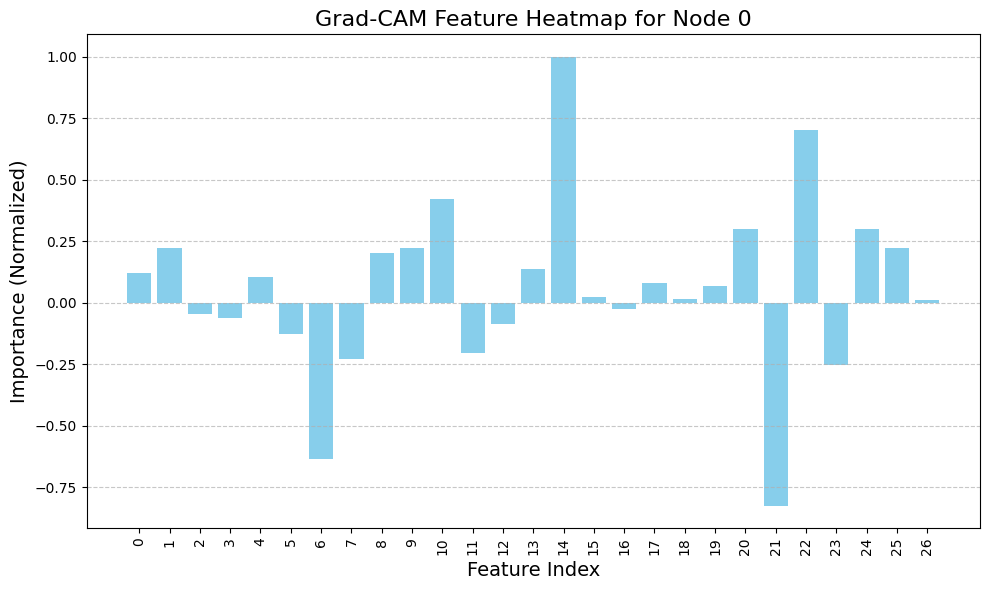


Processing Grad-CAM for Node 10...


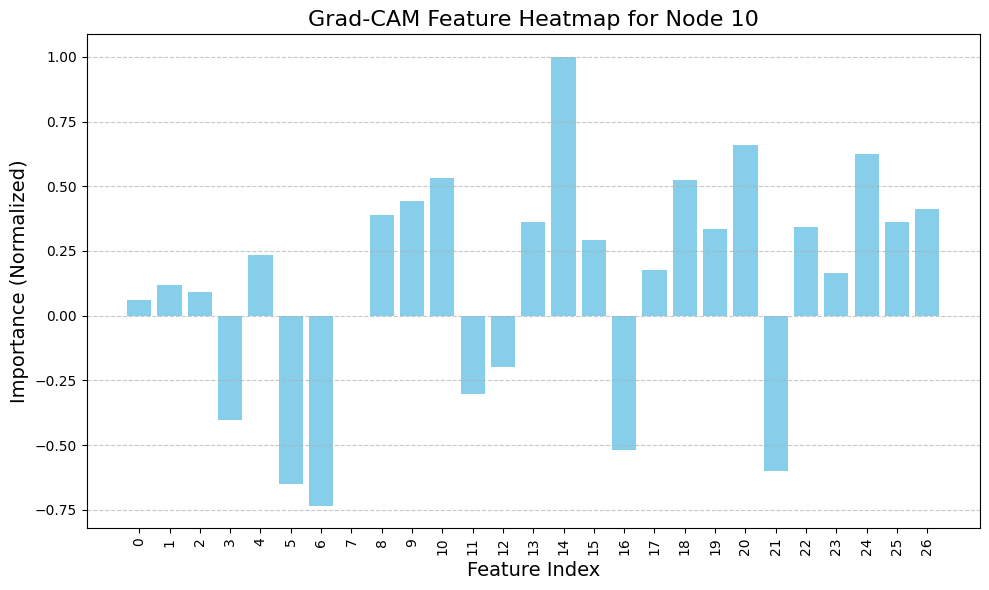


Processing Grad-CAM for Node 20...


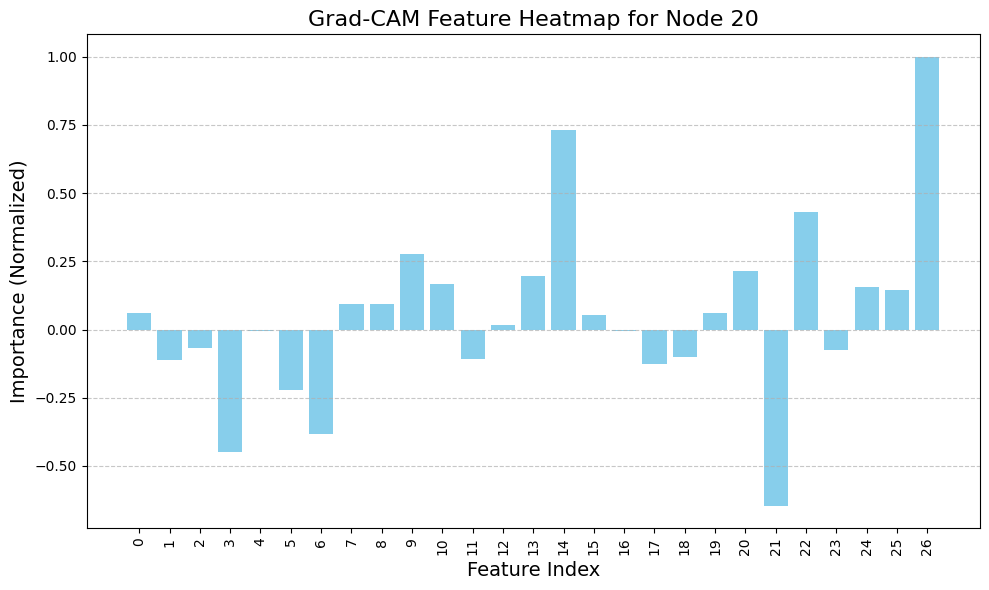


Processing Grad-CAM for Node 50...


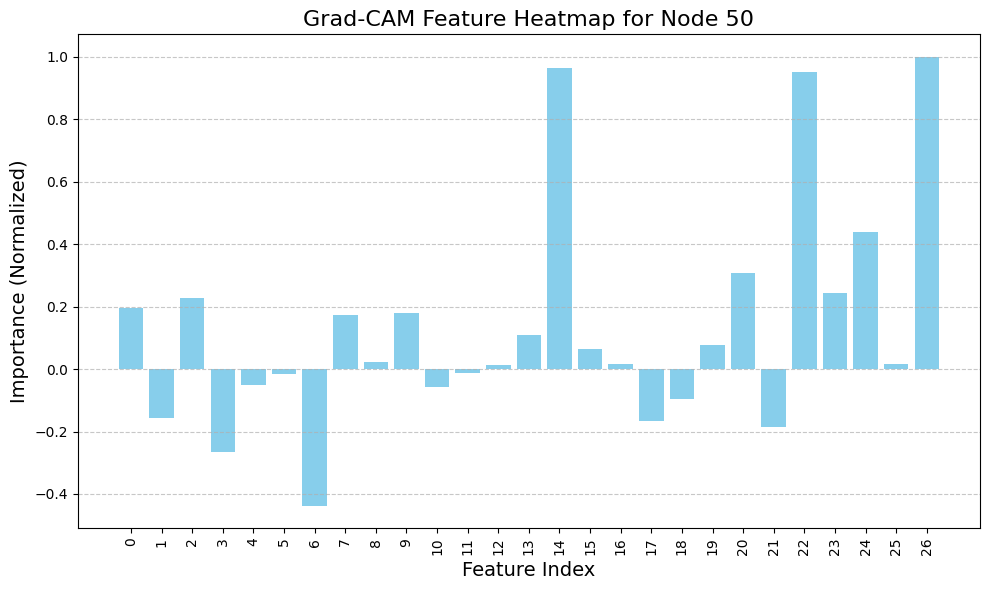

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad

def grad_cam_node(node_idx, data, model):
    model.eval()
    data = data.to(device)
    data.x.requires_grad = True  # Enable gradients for the input features

    # Forward pass
    out = model(data.x, data.edge_index)
    target_class = out[node_idx].argmax()

    # Backward pass for the target class
    model.zero_grad()
    out[node_idx, target_class].backward()

    # Calculate Grad-CAM heatmap
    node_grad = data.x.grad[node_idx].cpu().numpy()
    heatmap = node_grad / (node_grad.max() + 1e-8)  # Normalize
    return heatmap

def visualize_heatmap(heatmap, node_idx):
    # Create a bar plot for the Grad-CAM heatmap
    plt.figure(figsize=(10, 6))
    feature_indices = np.arange(len(heatmap))
    plt.bar(feature_indices, heatmap, color="skyblue")
    plt.xlabel("Feature Index", fontsize=14)
    plt.ylabel("Importance (Normalized)", fontsize=14)
    plt.title(f"Grad-CAM Feature Heatmap for Node {node_idx}", fontsize=16)
    plt.xticks(feature_indices, rotation=90)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

def grad_cam_multiple_nodes(node_indices, data, model):
    for node_idx in node_indices:
        print(f"\nProcessing Grad-CAM for Node {node_idx}...")
        heatmap = grad_cam_node(node_idx, data, model)  # Get heatmap for the node
        visualize_heatmap(heatmap, node_idx)  # Visualize the heatmap

# Example: Apply Grad-CAM for multiple nodes
node_indices = [0, 10, 20, 50]  # Replace with specific node indices you want to analyze
grad_cam_multiple_nodes(node_indices, data, gin_model)
